## Installing required libs (if not done in the conda env.)

In [ ]:
pip install open3d

In [ ]:
pip install laspy

## Importing Libraries

In [3]:
import open3d as o3d
import numpy as np
import laspy as lp

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [32]:
pcd = lp.read("33CN2_16_clip.las")
#pcd = lp.read("33CN2_14.LAZ")

print([dimension.name for dimension in pcd.point_format.dimensions])
print(np.max(pcd.green))

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue', 'nir']
252


In [47]:
points = np.vstack((pcd.x, pcd.y, pcd.z)).transpose()
colors = np.vstack((pcd.red, pcd.green, pcd.blue)).transpose()
#colors = np.vstack((pcd.intensity, pcd.intensity, pcd.intensity)).transpose()

## Pre-Processing

In [20]:
factor = 8 
decimated_points_random = points[::factor]
decimated_colors_random = colors[::factor]

print("points Number before:", len(points))
print("Points Number after:", len(decimated_points_random))

points Number before: 1832185
Points Number after: 229024


## Visualization

- To normalize the RGB values (i.e. making its values between 0 and 1) we devide by 255 If the RGB values are in the 8-bit range (where each channel value is between 0 and 255).
- When the RGB values are in the range of 16-bit color depth (where each channel value can range from 0 to 65535), you would normalize by dividing by 65535.

In [48]:
point_clouds = o3d.geometry.PointCloud()
point_clouds.points = o3d.utility.Vector3dVector(points)
point_clouds.colors = o3d.utility.Vector3dVector(colors/255) 

o3d.visualization.draw_geometries([point_clouds])

## Editing Mode:

You can also visualize your point clouds and edit it interactively using the next function.

- You can press "y" to align the geomtry with the negative direction of y-axis (also applicable for "x").
- You can use "z" to return to the top ortho-view. 
- Press "k" to lock screen and switch to selection mode..
- Then you can use left click for rectangle selection..
- or use ctrl + left click for polygon selection.
- Press "s" to save the selected geometry.
- Press "f" to switch to selection mode.

In [49]:
o3d.visualization.draw_geometries_with_editing([point_clouds])

## Segmentation
 -  [The Segment Anything Model (SAM)](https://segment-anything.com/)
 - [SAM 2.0 GitHub](https://github.com/facebookresearch/segment-anything-2)

## Imports

In [1]:
import os
import laspy #pip install laspy
import numpy as np
import math
from PIL import Image #pip install pillow
import torch #pip install torch
import CSF #pip install cloth-simulation-filter
import cv2 #pip install opencv-python
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import supervision as sv
import matplotlib.pyplot as plt

#if using Apple MPS, fall back to CPU for unsupported ops (uncomment the below line)
#os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
    #device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.")

using device: cpu


In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [4]:
image = Image.open('cars.jpg')
image = np.array(image.convert("RGB"))

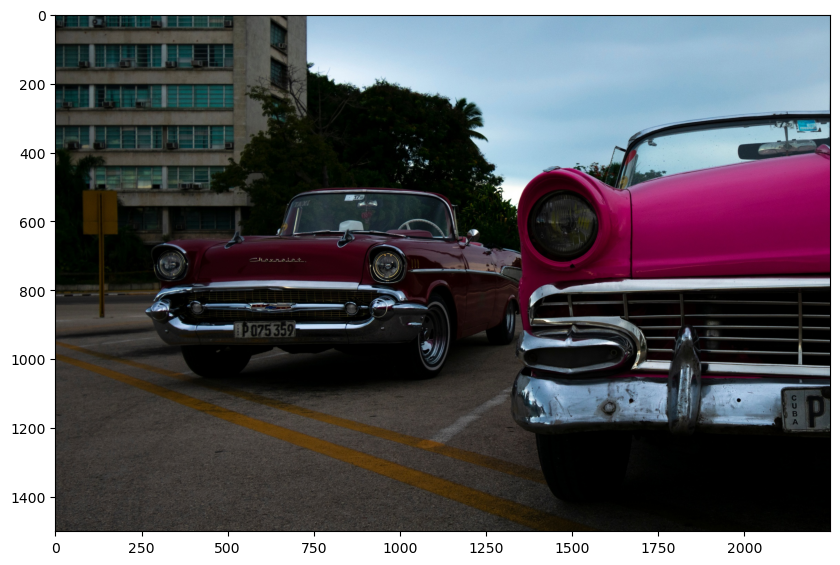

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. 

In [25]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = r"z:\segment-anything\sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 6553600 bytes.

To generate masks, just run `generate` on an image

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- `segmentation` : the mask
- `area` : the area of the mask in pixels
- `bbox` : the boundary box of the mask in XYWH format
- `predicted_iou` : the model's own prediction for the quality of the mask
- `point_coords` : the sampled input point that generated this mask
- `stability_score` : an additional measure of mask quality
- `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

## .tif files 

Try repeating the same above steps using a .tif file as an input...

## 3D pointclouds 

## Rotation & Transformation Matrices

In [21]:
# Define the input file
INPUT_LAS_FILE = r"C:\Users\Mahmo\Downloads\33CN2_16_clip.las"

# Read the LAS file 
las = laspy.read(INPUT_LAS_FILE)

# Get the XYZ and RGB values from the LAS file
x = las.x
y = las.y
z = las.z
r = las.red / 256.0
g = las.green / 256.0
b = las.blue / 256.0

In [22]:
csf = CSF.CSF()
xyz = np.vstack((x, y, z)).transpose()
csf.setPointCloud(xyz)

In [23]:
csf = CSF.CSF()
xyz = np.vstack((x, y, z)).transpose()
csf.setPointCloud(xyz)
csf.getPointCloud

<bound method CSF.getPointCloud of <CSF.CSF; proxy of <Swig Object of type 'CSF *' at 0x0000022DF2A59150> >>

In [24]:
# Define the output resolution 
RESOLUTION = 1.0  # meters, it means 5cm 

# Calculate the output dimensions and range
xmin = x.min()  * RESOLUTION
xmax = x.max()  * RESOLUTION
ymin = y.min()  * RESOLUTION
ymax = y.max()  * RESOLUTION
width = int((xmax - xmin) / RESOLUTION)
height = int((ymax - ymin) / RESOLUTION)

# Create a new image with the calculated dimensions and fill it with black pixels
image = Image.new("RGB", (width, height), (0, 0, 0))

# Iterate over the LAS points and convert them to image coordinates
for xi, yi, zi, ri, gi, bi in zip(x, y, z, r, g, b):
    col = int((xi - xmin) / RESOLUTION)
    row = int((ymax - yi) / RESOLUTION)
    if col >= 0 and col < width and row >= 0 and row < height:
        color = (int(round(ri)), int(round(gi)), int(round(bi)))
        image.putpixel((col, row), color)

# Save the image as a JPEG file
Orthophoto = "output.jpg"
image.save(Orthophoto, "JPEG")

In [ ]:
# Define the camera position and angles of the different views
camera_pos = (0, 0, 80)
angles = [(-60, 0), (60, 0), (0, -60), (0, 60)]

# Iterate over the angles and generate images for each angle
for angle in angles:
    # Convert the angles to radians
    theta_x = math.radians(angle[0])
    theta_y = math.radians(angle[1])

    # Calculate the rotation matrices
    rotation_matrix_x = np.array([[1, 0, 0],
                                  [0, math.cos(theta_x), -math.sin(theta_x)],
                                  [0, math.sin(theta_x), math.cos(theta_x)]])

    rotation_matrix_y = np.array([[math.cos(theta_y), 0, math.sin(theta_y)],
                                  [0, 1, 0],
                                  [-math.sin(theta_y), 0, math.cos(theta_y)]])

    # Apply the rotation matrices to the (x, y, z) coordinates
    xyz = np.vstack((x, y, z)).T
    xyz = np.dot(xyz - camera_pos, rotation_matrix_x)
    xyz = np.dot(xyz, rotation_matrix_y) + camera_pos

    # Extract the rotated x, y, and z coordinates
    x_rotated = xyz[:, 0]
    y_rotated = xyz[:, 1]
    z_rotated = xyz[:, 2]

    # Calculate the output dimensions and range for the rotated point cloud
    xmin_rotated = x_rotated.min() - RESOLUTION
    xmax_rotated = x_rotated.max() + RESOLUTION
    ymin_rotated = y_rotated.min() - RESOLUTION
    ymax_rotated = y_rotated.max() + RESOLUTION
    width_rotated = int((xmax_rotated - xmin_rotated) / RESOLUTION)
    height_rotated = int((ymax_rotated - ymin_rotated) / RESOLUTION)

    # Create a new image with the calculated dimensions and fill it with black pixels
    image = Image.new("RGB", (width_rotated, height_rotated), (0, 0, 0))

    # Iterate over the rotated points and convert them to image coordinates
    for xi, yi, zi, ri, gi, bi in zip(x_rotated, y_rotated, z_rotated, r, g, b):
        col = int((xi - xmin_rotated) / RESOLUTION)
        row = int((ymax_rotated - yi) / RESOLUTION)
        if col >= 0 and col < width_rotated and row >= 0 and row < height_rotated:
            # Set the pixel color
            image.putpixel((col, row), (int(ri), int(gi), int(bi)))

    # Save the image as a JPEG file
    image.save("output_{}_{}.jpg".format(angle[0], angle[1]), "JPEG")

## Extras

- [`Create a 3D model using phone LIDAR`](https://www.youtube.com/watch?v=9heI3BTx9fc&list=WL&index=16&t=28s)
- [`Use SAM in multi-angles for point cloud segmantation`](https://medium.com/@OttoYu/point-cloud-segmentation-with-sam-in-multi-angles-add5a5c61e67)
An analternative free-of-charge app to Polygam is Scaniverse (found in Apple Appstore for iphones and ipads, not sure for Android! :)) 
- [`PDAL filters.transformation`](https://pdal.io/en/latest/stages/filters.transformation.html#matrix)
-  [`Fit a stem vector to TLS trees data`](https://laempy.github.io/pyoints/tutorials/stem_detection.html)

### Transformation & ICP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import copy

In [ ]:
source = o3d.io.read_point_cloud()
target = o3d.io.read_point_cloud()

In [ ]:
o3d.visualization.draw_plotly([source],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

In [ ]:
o3d.visualization.draw_plotly([target],
                                  zoom=0.455,
                                  front=[-0.4999, -0.1659, -0.8499],
                                  lookat=[2.1813, 2.0619, 2.0999],
                                  up=[0.1204, -0.9852, 0.1215])

In [ ]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_plotly([source_temp, target_temp])

Intitial transformation to initialize the registration

In [ ]:
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])

In [ ]:
draw_registration_result(source, target, trans_init)

In [ ]:
threshold=0.02
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

## Start the Iterative Closest Point (Point-to-Point)

In [ ]:
threshold=0.02
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

In [ ]:
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

## Start the Iterative Closest Point (Point-to-Plane)

In [ ]:
threshold=0.02
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)